<a href="https://colab.research.google.com/github/DS-JPark/exploring_historical_SP500_daily_closing_prices/blob/main/exploring_historical_SP500_daily_closing_prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview
This notebook explores historical S&P 500 daily closing prices to answer two key questions:

- **Benford's Law Analysis**: Do the leading digits of the stock prices follow the expected logarithmic distribution of Benford’s Law?

- **Return Analysis**: What are the worst and average-case scenarios over rolling 5-year investment periods?

It combines data retrieval, statistical analysis, and visualization to uncover insights about financial patterns and risk across time.

## 1. Imports and Setup

In [ ]:
!pip install yfinance

In [58]:
from datetime import datetime, date, timedelta

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chisquare

## 2. Functions

In [34]:
def fetch_leading_digit(n:float) -> int:
  """Returns the leading (first non-zero) digit of a positive number.

  For any positive float or integer input, the function normalizes the
  number and extracts the first digit. If the number is 0 or negative,
  the function returns NA.

  Args:
    n: A float or int number from which to extract the leading digit.

  Returns:
    An integer representing the leading digit (1–9), or `pd.NA` if the input
    is zero or negative.
  """

  if n <= 0:
    return pd.NA
  while n < 1:
    n *= 10
  return int(str(n)[0])

In [39]:
def get_benfords_probs() -> np.ndarray:
  """Returns the expected leading-digit probabilities according to Benford's Law.

  Benford's Law predicts the distribution of first digits in naturally occurring
  datasets. The probability of each digit d (1 through 9) is given by:

    P(d) = log10(1 + 1/d)

  Returns:
    A NumPy array of shape (9,) containing the probabilities for digits 1 to 9.
  """

  return np.array([np.log10(1 + 1/d) for d in range(1, 10)])

## 3. Data Retrieval & Visualization

In [49]:
# Fetch historical S&P 500 data
sp500 = yf.Ticker("^GSPC")
sp500_data = sp500.history(period="max")[['Close']].copy()

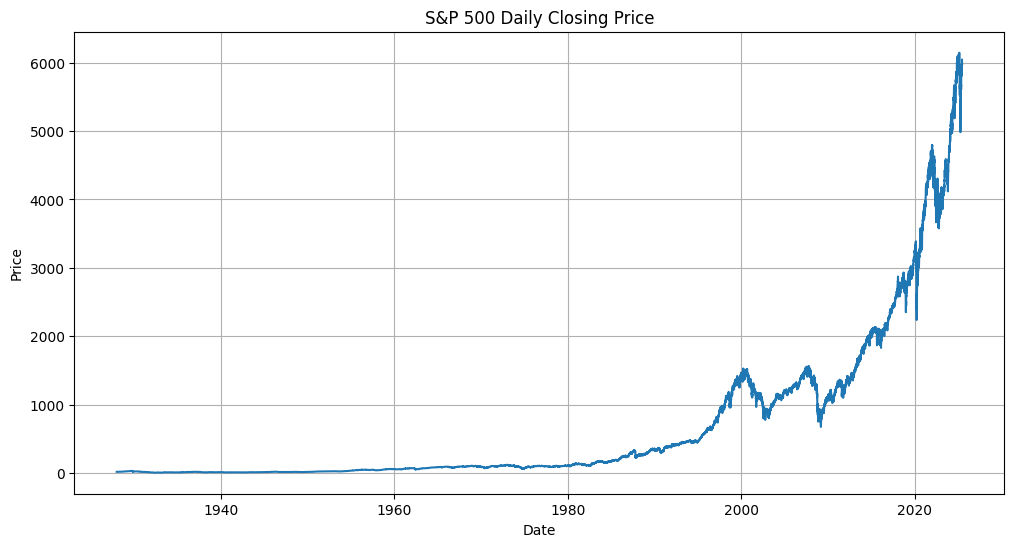

In [ ]:
# Plot the closing price
plt.figure(figsize=(12, 6))
plt.plot(sp500_data['Close'])
plt.title('S&P 500 Daily Closing Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

## 4. Benford's Law Test

In [46]:
# Check if the closing price obeys Benfords Law
leading_digits = sp500_data['Close'].map(fetch_leading_digit)
digit_counts = leading_digits.value_counts().sort_index()

# Make sure all digits are represented
for d in range(1, 10):
  if d not in digit_counts.index:
    digit_counts[d] = 0

digit_counts = digit_counts.sort_index()
total = digit_counts.sum()
expected_counts = get_benfords_probs() * total

chi2_stat, p_value = chisquare(f_obs=digit_counts, f_exp=expected_counts)

print(f'Chi-squared statistic: {chi2_stat:.2f}')
print(f'P-value: {p_value:.4f}')

if p_value < 0.05:
    print("The data does NOT follow Benford's Law.")
else:
    print("The data may follow Benford's Law.")

Chi-squared statistic: 4739.90
P-value: 0.0000
The data does NOT follow Benford's Law.


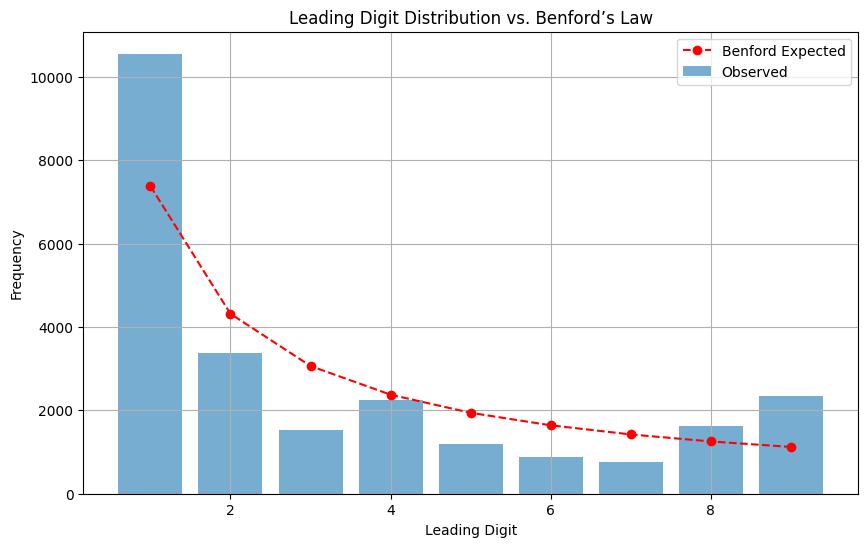

In [47]:
plt.figure(figsize=(10, 6))
plt.bar(range(1, 10), digit_counts.values, alpha=0.6, label='Observed')
plt.plot(range(1, 10), expected_counts, marker='o', linestyle='--', color='red', label='Benford Expected')
plt.xlabel('Leading Digit')
plt.ylabel('Frequency')
plt.title('Leading Digit Distribution vs. Benford’s Law')
plt.legend()
plt.grid(True)
plt.show()

## 5. Return Analysis

In [56]:
log_df = pd.DataFrame(sp500_data['Close'])
log_df['LogReturn'] = np.log(log_df['Close'] / log_df['Close'].shift(1))

# Drop missing values
log_df = log_df.dropna(subset=['LogReturn'])

# Set window size to approximately 5 years of trading days
TRADING_DAYS_IN_YEAR = 252
num_years = 5
window_size = num_years * TRADING_DAYS_IN_YEAR

# Rolling 5-year cumulative log return
log_df['RollingLogReturn'] = (
    log_df['LogReturn'].rolling(window=window_size).sum()
  )

# Convert log return to percentage
log_df['RollingPctReturn'] = np.exp(log_df['RollingLogReturn']) - 1

total_windows = log_df['RollingPctReturn'].count()
negative_windows = (log_df['RollingPctReturn'] < 0).sum()
percentage_negative = negative_windows / total_windows * 100

print(
    f"Out of {total_windows:.0f} rolling 5-year windows,\
 {negative_windows:.0f} ended in a loss."
  )
print(f"That's about {percentage_negative:.2f}% of all 5-year periods.")

Enter the number of years: 5
Out of 23252 rolling 5-year windows, 4601 ended in a loss.
That's about 19.79% of all 5-year periods.


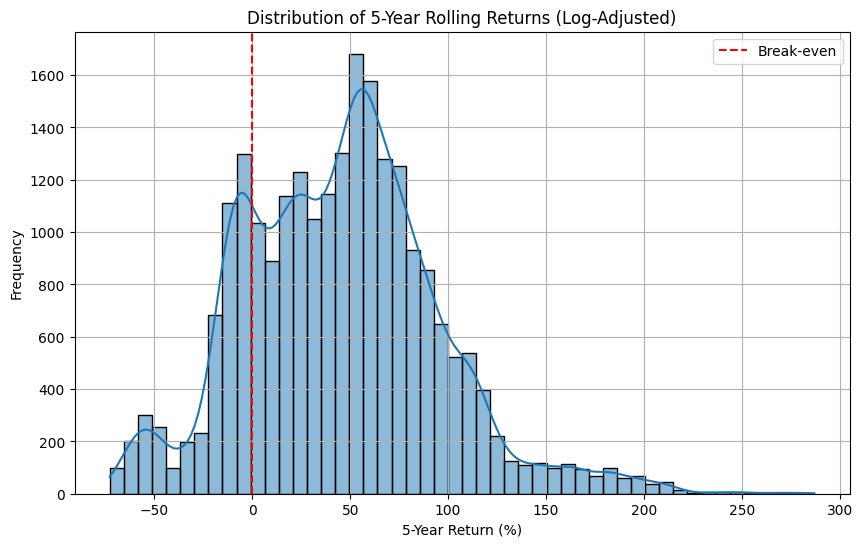

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(log_df['RollingPctReturn'].dropna() * 100, bins=50, kde=True)
plt.axvline(0, color='red', linestyle='--', label='Break-even')
plt.title('Distribution of 5-Year Rolling Returns (Log-Adjusted)')
plt.xlabel('5-Year Return (%)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()